In [1]:
'''
Plotting libraries
'''
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import  time
#%matplotlib inline

'''
What we'll need for analysis, clustering, etc.
'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

'''
Of course the powerful RDKIT for cheminformatics 
'''
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
from rdkit.Chem import PandasTools
'''
Some utilities
'''
import progressbar
from math import pi

#%config Completer.use_jedi = False
PandasTools.RenderImagesInAllDataFrames(images=True)
IPythonConsole.ipython_useSVG = True 
import mols2grid
from tqdm import tqdm, tqdm_notebook
from ipywidgets import widgets

In [2]:
data_task = r'D:\Projetos academicos\Labmol\Code\chemspace\clinical_results\cli_temp\Sparse_Clinical_Hepato_mMol.csv'

data_task = pd.read_csv(data_task, delimiter=',', low_memory=False)

data_task.head(5)

,ID,SMILES,Clinical_Filtered Abnormal Hepatic Fun _IC50,Clinical_Filtered Cholecystiti_IC50,Clinical_Filtered Cholelitiasi_IC50,Clinical_Filtered Cholestasi_IC50,Clinical_Filtered cholestatic Jaundice_IC50,Clinical_Filtered Hepatic Failure_IC50,Clinical_Filtered Hepatic necrosi_IC50,Clinical_Filtered Hepatic Steatosi_IC50,Clinical_Filtered Hepatiti_IC50,Clinical_Filtered HepatoBiliary disorder_IC50,Clinical_Filtered HepatoCellular injury_IC50,Clinical_Filtered Hepatomegaly_IC50,Clinical_Filtered Hepatotoxicity_IC50,Clinical_Filtered Hyperbilirubinemia_IC50,Clinical_Filtered Jaundice_IC50,Clinical_Filtered Liver Injury_IC50
0,0,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,3.098676,3.098676,NaN,NaN,NaN,3.251697,NaN,3.098676,NaN,NaN,NaN,NaN,3.098676,NaN,NaN,3.098676
1,1,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,-0.198421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.318286,NaN,NaN,NaN,NaN
2,2,C/C([O-])=N/c1nnc(S(N)(=O)=O)s1,4.589035,NaN,NaN,NaN,-0.311166,-0.114166,-0.311166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,CC(C)(C)C(=O)OCOP(=O)(COCCn1cnc2c(N)ncnc21)OCO...,2.611212,NaN,NaN,NaN,NaN,2.611212,2.469738,2.469738,2.478072,NaN,NaN,2.498092,NaN,2.652715,2.442580,NaN
4,4,COc1ccc2cccc(CCNC(C)=O)c2c1,2.445331,NaN,NaN,NaN,NaN,2.269967,NaN,NaN,2.338544,NaN,NaN,NaN,2.434901,NaN,2.271438,NaN


# Build the dense matrix

In [3]:
count = 0

space = {"SMILES":[],"TASKS":[],"VALUE":[]}

col = [col for col in data_task.columns]
col = col[2:]
#col[i+3]
#space = {k:[] for k in col} 

for j in range(data_task.shape[0]):
    
    i =  data_task.shape[1]
    r_col = [v for v in data_task.iloc[j,2:i]]
    
    if None not in r_col or np.nan not in r_col :
        
        for i,v in enumerate(r_col):
            
                if v == v: # nan is never equal to itself for some reason
                    
                    space["TASKS"].append(col[i])
                    space["VALUE"].append(v)
                    space["SMILES"].append(data_task["SMILES"][j])
  
dense_df = pd.DataFrame(space)


In [4]:
data_space = dense_df

data_space.head(100) 

,SMILES,TASKS,VALUE
0,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Abnormal Hepatic Fun _IC50,3.098676
1,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Cholecystiti_IC50,3.098676
2,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Hepatic Failure_IC50,3.251697
3,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Hepatic Steatosi_IC50,3.098676
4,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Hepatotoxicity_IC50,3.098676
...,...,...,...
95,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,Clinical_Filtered Abnormal Hepatic Fun _IC50,3.745195
96,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,Clinical_Filtered cholestatic Jaundice_IC50,2.555236
97,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,Clinical_Filtered Hepatic Failure_IC50,2.593666
98,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,Clinical_Filtered Hepatic necrosi_IC50,3.745195


In [5]:
data_space.shape # to confirm if the shape is higher 

(2694, 3)

# Calculate the Scaffolds

Enable Pandas **progress_apply**

In [5]:
tqdm.pandas()

In [6]:
data_task['framework'] = data_task.SMILES.apply(MurckoScaffoldSmilesFromSmiles)

In [7]:
data_task['mol'] = data_task.SMILES.apply(Chem.MolFromSmiles)

,ID,SMILES,Clinical_Filtered Abnormal Hepatic Fun _IC50,Clinical_Filtered Cholecystiti_IC50,Clinical_Filtered Cholelitiasi_IC50,Clinical_Filtered Cholestasi_IC50,Clinical_Filtered cholestatic Jaundice_IC50,Clinical_Filtered Hepatic Failure_IC50,Clinical_Filtered Hepatic necrosi_IC50,Clinical_Filtered Hepatic Steatosi_IC50,Clinical_Filtered Hepatiti_IC50,Clinical_Filtered HepatoBiliary disorder_IC50,Clinical_Filtered HepatoCellular injury_IC50,Clinical_Filtered Hepatomegaly_IC50,Clinical_Filtered Hepatotoxicity_IC50,Clinical_Filtered Hyperbilirubinemia_IC50,Clinical_Filtered Jaundice_IC50,Clinical_Filtered Liver Injury_IC50,framework,mol
0,0,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,3.098676,3.098676,NaN,NaN,NaN,3.251697,NaN,3.098676,NaN,NaN,NaN,NaN,3.098676,NaN,NaN,3.098676,c1cc(-c2ccc3nc[nH]c3c2)nc(Nc2ccc(CN3CCNCC3)cn2)n1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1,1,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,-0.198421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.318286,NaN,NaN,NaN,NaN,c1ccccc1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
2,2,C/C([O-])=N/c1nnc(S(N)(=O)=O)s1,4.589035,NaN,NaN,NaN,-0.311166,-0.114166,-0.311166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c1nncs1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
3,3,CC(C)(C)C(=O)OCOP(=O)(COCCn1cnc2c(N)ncnc21)OCO...,2.611212,NaN,NaN,NaN,NaN,2.611212,2.469738,2.469738,2.478072,NaN,NaN,2.498092,NaN,2.652715,2.442580,NaN,c1ncc2nc[nH]c2n1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
4,4,COc1ccc2cccc(CCNC(C)=O)c2c1,2.445331,NaN,NaN,NaN,NaN,2.269967,NaN,NaN,2.338544,NaN,NaN,NaN,2.434901,NaN,2.271438,NaN,c1ccc2ccccc2c1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
5,5,N=C(N)NC(=O)c1nc(Cl)c(N)nc1N,2.320353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c1cnccn1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
6,6,Nc1ccc(C(=O)O)c(O)c1,-1.521420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.901809,NaN,NaN,-1.378930,NaN,NaN,-1.215907,NaN,c1ccccc1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
7,7,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCCN(CC)CC)c(I)c1,-0.391998,-0.113959,NaN,NaN,NaN,NaN,-0.069446,NaN,2.689187,NaN,-0.069446,-0.503869,-0.310297,NaN,-0.078417,NaN,O=C(c1ccccc1)c1coc2ccccc12,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
8,8,C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@...,2.684902,2.672303,NaN,NaN,NaN,2.656793,NaN,NaN,0.000000,NaN,2.513369,2.981440,2.706924,0.000000,2.672303,NaN,O=C1CCCCCCCCCCCC2CCCC(CC(OC3CCCCO3)C=CC=CC=CC=...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
9,9,O=C1CN2Cc3c(ccc(Cl)c3Cl)N=C2N1,2.114984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.028326,NaN,NaN,NaN,NaN,NaN,2.034902,NaN,O=C1CN2Cc3ccccc3N=C2N1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

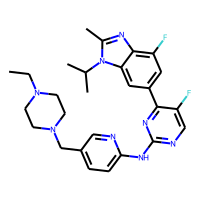
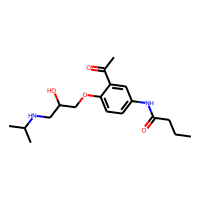
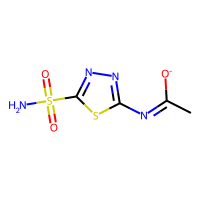
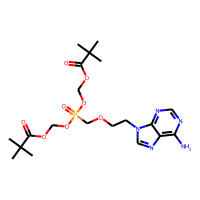
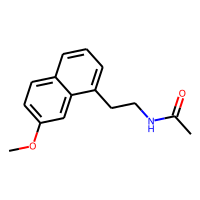
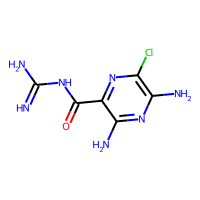
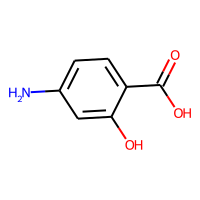
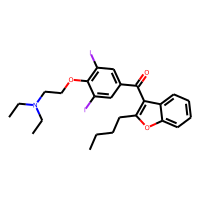
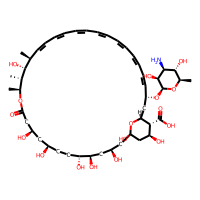
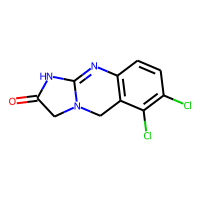

In [8]:
data_task.head(10)

In [9]:
scaffold_df = data_task.groupby('framework').agg({'framework':'size'})
scaffold_df=scaffold_df.rename(columns={'framework':'count'})
scaffold_df.head()

,count
framework,
,27
C(=C(c1ccccc1)c1ccccc1)c1ccccc1,1
C(=Cc1ccc2ccccc2n1)c1cccc(C(CCc2ccccc2)SCC2CC2)c1,1
C(=Cc1n[nH]c2cc(Sc3ccccc3)ccc12)c1ccccn1,1
C(=[SH]c1nc2ccccc2[nH]1)c1ccccn1,1


In [10]:
#reseting the index
scaffold_df=scaffold_df.reset_index()
scaffold_df['scaffold_idx'] = scaffold_df.index
scaffold_df=scaffold_df.rename(columns={'framework':'scaffold'})
scaffold_df=scaffold_df.sort_values(by=['count'], ascending=False)
scaffold_df.head()

,scaffold,count,scaffold_idx
420,c1ccccc1,28,420
0,,27,0
157,O=C1C=C2CCC3C4CCCC4CCC3C2CC1,7,157
162,O=C1C=CC2C(=C1)CCC1C3CCCC3CCC21,6,162
415,c1ccc2ccccc2c1,6,415


# Reduction of dimensionality

In [12]:
import os
import time
from typing import List

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

ModuleNotFoundError: No module named 'umap'

In [13]:
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list: data_space["SMILES"]):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)
    
    return None

In [14]:
# Compute desrciptors and keep track of which failed to featurize
smiles2 = list(data_space["SMILES"])
smi2=[Chem.MolFromSmiles(x) for x in smiles2]

#Calculate descriptors
fps  = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048) for x in smi2] # Morgan
#fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # MACCSKeys
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(data_space["SMILES"])

# Only keep those that sucessfully featurized
data_set = data_space.iloc[keep_idx]

In [15]:
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors2(smiles_list: scaffold_df["scaffold"]):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp2 = _compute_single_ecfp_descriptor2(smiles)
        if ecfp2 is not None:
            keep_idx.append(i)
            descriptors.append(ecfp2)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor2(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp2 = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp2)
    
    return None

In [16]:
# Compute desrciptors and keep track of which failed to featurize
smiles = list(scaffold_df["scaffold"])
smi=[Chem.MolFromSmiles(x) for x in smiles]

#Calculate descriptors
fps_2  = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048) for x in smi] # Morgan
#fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # MACCSKeys
ecfp_descriptors2, keep_idx = compute_ecfp_descriptors2(scaffold_df["scaffold"])

# Only keep those that sucessfully featurized
data_set2 = data_space.iloc[keep_idx]

In [17]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

Reduction of dimensionality: **Calculate computational cost per reduction method with descriptor-related to scaffolds data set**  

In [18]:
%%time
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 50,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(fps_2)
scaffold_df["UMAP_0"], scaffold_df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 5732 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


Wall time: 8.35 s


In [19]:
%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors2)
scaffold_df["PCA_0"], scaffold_df["PCA_1"] = X_pca[:,0], X_pca[:,1]

Wall time: 56.4 ms


In [20]:
%%time
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors2)
scaffold_df["TNSE_0"], scaffold_df["TNSE_1"] = X_tsne[:,0], X_tsne[:,1]

Wall time: 1.88 s


Reduction of dimensionality: **Calculate computational cost per reduction method with descriptor-related to SMILES data set**

In [55]:
%%time
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 200,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(fps)
data_space["UMAP_0"], data_space["UMAP_1"] = X_umap[:,0], X_umap[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1802: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable



Wall time: 28.2 s


In [22]:
%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
data_space["PCA_0"], data_space["PCA_1"] = X_pca[:,0], X_pca[:,1]

Wall time: 172 ms


In [23]:
%%time
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
data_space["TNSE_0"], data_space["TNSE_1"] = X_tsne[:,0], X_tsne[:,1]

Wall time: 17.6 s


In [24]:
def plot_global_embeddings_with_clusters(df: pd.DataFrame,
                          x_col: str,
                          y_col: str,
                          cluster_col: str,
                          title: str = "",
                          x_lim = None,
                          y_lim = None):
    """ Plots data colored by soft HDBSCAN clusters
    
    If the cluster of a compund is not specified (cluster < 0), it will be
    plotted gray, otherwise it will be colored by the cluster value.
    """
    clustered = df[cluster_col].values >= 0
    
    plt.figure(figsize=(10,8))
    ax=sns.scatterplot(data=df.iloc[~clustered],
                    x=x_col,
                    y=y_col,
                    color=(0.5, 0.5, 0.5),
                    s=10,
                    alpha=0.1)
    sns.scatterplot(data=df.iloc[clustered],
                    x=x_col,
                    y=y_col,
                    hue=cluster_col,
                    alpha=0.5,
                    palette="nipy_spectral",
                    ax=ax)
    if x_lim:
      ax.set_xlim(x_lim)
    if y_lim:
      ax.set_ylim(y_lim)

    sm = plt.cm.ScalarMappable(cmap="nipy_spectral")
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm, label="Global Cluster")
  
    plt.title(title)
    plt.show()

In [25]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
for method in ["UMAP", "PCA", "TNSE"]:
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=data_space,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    hue="TASKS",bet
                    alpha=0.5,
                    palette=palette)
    plt.title(f"{method}  Dataset")
    plt.show()

SyntaxError: invalid syntax (<ipython-input-25-803ea13153d1>, line 8)

# Calculate descriptors - Smiles

In [26]:
smiles = list(data_space["SMILES"])
smi=[Chem.MolFromSmiles(x) for x in smiles]

#Calculate descriptors
fps  = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048) for x in smi] # ECFP4
#fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # MACCSKeys
tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps) #This compute a similartity matrix between all the molecules
n_mol = len(fps)
similarity_matrix = np.ones([n_mol,n_mol])
i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
distance_matrix = np.subtract(1,similarity_matrix) #This is the similarity matrix of all vs all molecules in our table

In [27]:
#Diminui a dimensionalidade do meu modelo de uma matriz de 214x214 para uma matriz de 214x2
TSNE_sim = TSNE(n_components=2,init='random',random_state=1000, angle = 0.2,perplexity=50, early_exaggeration = 12.0).fit_transform(distance_matrix) #Escolher os melhores valores dos hiperparametros!!
tsne_result = pd.DataFrame(data = TSNE_sim , columns=["TC1","TC2"]) # New table containing the tSNE results
tsne_result #A new table containing the tSNE results

,TC1,TC2
0,1.454202,-24.437254
1,1.454202,-24.437254
2,1.454202,-24.437254
3,1.454202,-24.437254
4,1.454202,-24.437254
...,...,...
2689,29.317627,35.172543
2690,-24.636414,-174.981247
2691,62.349487,-76.172569
2692,-21.265894,48.848629


# Calculate descriptors - data_set

In [28]:
smiles2 = list(scaffold_df["scaffold"])
smi2=[Chem.MolFromSmiles(x) for x in smiles2]

#Calculate descriptors
fps2  = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048) for x in smi2] # ECFP4
#fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # MACCSKeys
tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps2) #This compute a similartity matrix between all the molecules
n_mol = len(fps2)
similarity_matrix2 = np.ones([n_mol,n_mol])
i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
similarity_matrix2[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix2[i_upper] = similarity_matrix.T[i_upper] 
distance_matrix2 = np.subtract(1,similarity_matrix2) #This is the similarity matrix of all vs all molecules in our table

# Reduction of dimensionality - wiht t-SNE #

In [29]:
#Diminui a dimensionalidade do meu modelo de uma matriz de 214x214 para uma matriz de 214x2
TSNE_sim2 = TSNE(n_components=2,init='random',random_state=1000, angle = 0.2,perplexity=50, early_exaggeration = 12.0).fit_transform(distance_matrix2) #Escolher os melhores valores dos hiperparametros!!
tsne_result2 = pd.DataFrame(data = TSNE_sim2 , columns=["TC1","TC2"]) # New table containing the tSNE results
tsne_result2 #A new table containing the tSNE results

,TC1,TC2
0,-0.996925,-11.880596
1,-1.499700,-11.948761
2,-1.717602,-11.263502
3,-2.465399,-10.786956
4,-2.591637,-10.430768
...,...,...
537,-12.155701,16.709505
538,-12.210503,15.684675
539,-11.040504,15.738201
540,-11.120224,15.165572


In [ ]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")


#ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result,s=15,linewidth=0.2,alpha=1)
ax=sns.lmplot(x='TC1',y='TC2',data=tsne_result,fit_reg=False, legend=True,height=11,scatter_kws={"s":200, "alpha":0.3})        

plt.title('t-SNE Results: Proteases_ChEMBL', weight='bold').set_fontsize('14')
plt.xlabel ('tSNE 1', weight='bold').set_fontsize('10')
plt.ylabel ('tSNE 2', weight='bold').set_fontsize('10')


In [53]:
scaffold_df = scaffold_df.dropna(axis=0, how="any")
data_space.head()

,SMILES,TASKS,VALUE,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1,Cluster
0,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Abnormal Hepatic Fun _IC50,0.403639,-18.001715,6.383762,-0.710069,0.65952,-54.023903,16.301802,2
1,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Cholecystiti_IC50,0.403639,-17.991861,6.390082,-0.710069,0.65952,-54.023903,16.301802,2
2,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Hepatic Failure_IC50,0.283774,-18.018076,6.387735,-0.710069,0.65952,-52.248611,15.125135,2
3,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Hepatic Steatosi_IC50,0.403639,-18.000732,6.384448,-0.710069,0.65952,-54.023903,16.301802,2
4,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Hepatotoxicity_IC50,0.403639,-17.984331,6.375580,-0.710069,0.65952,-52.248611,15.125135,2


In [60]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16] # To explore the "best" number of cluster to clasify our molecules
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(data_space[['UMAP_0','UMAP_1']])
    silhouette_avg = silhouette_score(data_space[['UMAP_0','UMAP_1']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg) #This will print the silhouette score, as higher as our data is better distributed inside the clusters

For n_clusters = 2 The average silhouette_score is : 0.30843064
For n_clusters = 3 The average silhouette_score is : 0.3466505
For n_clusters = 4 The average silhouette_score is : 0.34976542
For n_clusters = 5 The average silhouette_score is : 0.38024876
For n_clusters = 6 The average silhouette_score is : 0.39772356
For n_clusters = 7 The average silhouette_score is : 0.38273177
For n_clusters = 8 The average silhouette_score is : 0.39301223
For n_clusters = 9 The average silhouette_score is : 0.42657992
For n_clusters = 10 The average silhouette_score is : 0.4415688
For n_clusters = 11 The average silhouette_score is : 0.41212463
For n_clusters = 12 The average silhouette_score is : 0.4037693
For n_clusters = 14 The average silhouette_score is : 0.4414333
For n_clusters = 15 The average silhouette_score is : 0.45984006
For n_clusters = 16 The average silhouette_score is : 0.44781312


In [33]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16] # To explore the "best" number of cluster to clasify our molecules
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(scaffold_df[['UMAP_0','UMAP_1']])
    silhouette_avg = silhouette_score(scaffold_df[['UMAP_0','UMAP_1']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg) #This will print the silhouette score, as higher as our data is better distributed inside the clusters

For n_clusters = 2 The average silhouette_score is : 0.4104422
For n_clusters = 3 The average silhouette_score is : 0.4298094
For n_clusters = 4 The average silhouette_score is : 0.4241367
For n_clusters = 5 The average silhouette_score is : 0.39788535
For n_clusters = 6 The average silhouette_score is : 0.4334995
For n_clusters = 7 The average silhouette_score is : 0.41893804
For n_clusters = 8 The average silhouette_score is : 0.41478753
For n_clusters = 9 The average silhouette_score is : 0.40937877
For n_clusters = 10 The average silhouette_score is : 0.3917358
For n_clusters = 11 The average silhouette_score is : 0.3947412
For n_clusters = 12 The average silhouette_score is : 0.39436898
For n_clusters = 14 The average silhouette_score is : 0.40831316
For n_clusters = 15 The average silhouette_score is : 0.41134045
For n_clusters = 16 The average silhouette_score is : 0.41023844


In [61]:
kmeans = KMeans(n_clusters=15, random_state=10) # We define the best number of clusters (3)
clusters = kmeans.fit(data_space[['UMAP_0','UMAP_1']]) #TC1vs TC2

data_space['Cluster'] = pd.Series(clusters.labels_, index=data_space.index)
data_space.to_excel(r"C:\Users\meryc\Downloads\UMAP_space_hepato_clinic.xlsx") #The tSNE table now contains the numer of cluster for each element

In [36]:
kmeans = KMeans(n_clusters=6, random_state=10) # We define the best number of clusters (3)
clusters = kmeans.fit(scaffold_df[['UMAP_0','UMAP_1']]) #TC1vs TC2

scaffold_df['Cluster'] = pd.Series(clusters.labels_, index=scaffold_df.index)
#data_space.to_excel(r"C:\Users\meryc\Downloads\UMAP_space_hepato_clinic.xlsx") #The tSNE table now contains the numer of cluster for each element

In [46]:
data_class = data_space.groupby('TASKS').agg({'Cluster':'size'})
data_class = data_space.rename(columns={'Cluster':'count'})
data_class

,SMILES,TASKS,VALUE,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1,count
0,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Abnormal Hepatic Fun _IC50,0.403639,-18.001715,6.383762,-0.710069,0.659520,-54.023903,16.301802,2
1,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Cholecystiti_IC50,0.403639,-17.991861,6.390082,-0.710069,0.659520,-54.023903,16.301802,2
2,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Hepatic Failure_IC50,0.283774,-18.018076,6.387735,-0.710069,0.659520,-52.248611,15.125135,2
3,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Hepatic Steatosi_IC50,0.403639,-18.000732,6.384448,-0.710069,0.659520,-54.023903,16.301802,2
4,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,Clinical_Filtered Hepatotoxicity_IC50,0.403639,-17.984331,6.375580,-0.710069,0.659520,-52.248611,15.125135,2
...,...,...,...,...,...,...,...,...,...,...
2689,CN1CC[C@@H](NC(=O)Nc2ccc(C#N)cc2)C[C@@H]1c1nc2...,Clinical_Filtered Liver Injury_IC50,0.262032,-2.282282,5.221129,-0.086028,0.483766,27.092413,-62.555782,8
2690,COC(=O)/C=C/C(=O)O,Clinical_Filtered Liver Injury_IC50,0.177143,2.162815,0.722932,-0.392545,-0.380236,6.019124,7.102659,11
2691,Cl.O=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CC...,Clinical_Filtered Liver Injury_IC50,-0.021225,8.234385,-1.489605,0.717147,-2.086696,-53.579903,35.109516,14
2692,CN(C)C(=O)Oc1cccc([N+](C)(C)C)c1.COS(=O)(=O)[O-],Clinical_Filtered Liver Injury_IC50,-5.447193,4.351635,3.036743,-0.451590,-0.131879,66.023300,5.054127,0


In [ ]:
space2 = {"CLASSE":[],"CONTAG_TASK":[]}

col = [col for col in data_space.columns]
col = col[2:]

for j in range(data_space.shape[0]):
    
    i =  data_space.shape[1]
    r_col = [v for v in data_space.iloc[j,2:i]]
    
    if None not in r_col or np.nan not in r_col :
        
        for i,v in enumerate(r_col):
            
                if v == v: # nan is never equal to itself for some reason
                    
                    space["CLASSE"] = 
                    space["VALUE"].append(v)
                    space["SMILES"].append(data_task["SMILES"][j])
  
classe_df = pd.DataFrame(space)

In [ ]:
data_space

In [ ]:
data_space['mol'] = data_space.SMILES.apply(Chem.MolFromSmiles)

In [ ]:
data_space

In [ ]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")


#ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result,s=15,linewidth=0.2,alpha=1)
ax=sns.lmplot(x='TC1',y='TC2',data=tsne_result,fit_reg=False, legend=True,height=11,palette=sns.color_palette("Set2", 4),scatter_kws={"s":200, "alpha":0.3})        

plt.title('t-SNE Results: Proteases_ChEMBL', weight='bold').set_fontsize('14')
plt.xlabel ('tSNE 1', weight='bold').set_fontsize('10')
plt.ylabel ('tSNE 2', weight='bold').set_fontsize('10')



In [ ]:
IPythonConsole.ipython_useSVG=True 
from IPython.display import SVG

data_space['mol']

In [63]:
from IPython.display import SVG
import plotly.express as px

df = data_space
X = data_space[['UMAP_0', 'UMAP_1', 'Cluster']]

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['Cluster'],   
    color_continuous_scale=['green','red'], 
    labels={'0': 'UMAP_0'}
)

fig.update_traces(marker_size=4)
fig.show()

In [48]:
from IPython.display import SVG
import plotly.express as px

df = scaffold_df
X = scaffold_df[['UMAP_0', 'UMAP_1', 'Cluster']]

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['Cluster'],   
    color_continuous_scale=['green','red'], 
    labels={'0': 'UMAP_0'}
)

fig.update_traces(marker_size=4)
fig.show()

# Reduction of dimensionality Global - Chemical Space #

# Embed dataset with UMAP, PCA, t-SNE (Dataset-Specific Embeddings) #